# SECOND DATA SET

## CS 579 Class Participant Data

## ASSUMPTIONS MADE WHILE CLEANING THE DATA:

- Each row of the dataset corresponds to a valid participant, and the columns beyond "Name" represent distinct entities (e.g., languages, skills, hobbies).  
- Empty or blank cells were ignored, meaning no edge was created for missing values.  
- Duplicate (participant, entity) pairs were dropped so that each connection appears only once in the graph.  


In [1]:
# Imports (keep ONE imports cell in the notebook)
import os, re, ast, glob
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bp


# 2) Load your single file (CSV or Excel)

In [17]:
%cd C:\Users\anuja\OneDrive\Desktop\A20563287_Assignment 2

C:\Users\anuja\OneDrive\Desktop\A20563287_Assignment 2


In [1]:
# (2a) Input file for the bipartite graph — CSV or Excel in the SAME folder
import os, glob
import pandas as pd

INPUT_PATH = "Social Network Data collection(Sheet1).csv"  

if not os.path.exists(INPUT_PATH):
    # fallback: pick first csv/xlsx next to the notebook
    candidates = glob.glob("*.csv") + glob.glob("*.xlsx") + glob.glob("*.xls")
    if not candidates:
        raise FileNotFoundError("No CSV/XLSX found in this folder.")
    INPUT_PATH = candidates[0]

ext = os.path.splitext(INPUT_PATH)[1].lower()
if ext in (".xlsx", ".xls"):
    df_raw = pd.read_excel(INPUT_PATH)
elif ext == ".csv":
    df_raw = pd.read_csv(INPUT_PATH)
else:
    raise ValueError("Please provide a .csv or .xlsx file.")

print("Loaded:", INPUT_PATH, "shape:", df_raw.shape)
df_raw.head()


Loaded: Social Network Data collection(Sheet1).csv shape: (98, 8)


,Illinois Tech email address,Department (if you have multiple depts please enter them all separated by a comma),Degree Program (if you are pursuing multiple degrees at Illinois Tech please enter them all separated by a comma),Neighborhood you reside in,Computer Languages (separate with comma),Languages spoken (separate with comma),Hobbies (separate with comma),Student club memberships (separate with comma)
0,mlaiz@illinoistech.edu,Computer Science,"Bachelor's Computer Science, Master's Artifici...",Downtown Skokie,"C, JavaScript, Java, Python","Tagalog, English","Reading, Rock Climbing, Watch Movies, Hang out...",DDAO
1,ionyeka@hawk.illinoistech.edu,Computer Science,Master's Artificial Intelligence,Bronzeville,"C#, Python, React, Angular, SQL","English, German","swimming, movies, football",NaN
2,nsmith40@hawk.illinoistech.edu,Computer Science,Master's Artificial Intelligence,Buena Park,"Python, C++, R, Java, SQLite",English,"reading, weightlifting, movies, leisure walks",NaN
3,cli124@hawk.illinoistech.edu,Computer Science,Master's Artificial Intelligence,"Shanghai, China","Python, R, Java, SQLite","English, Chinese",Watching plays and art exhibitions,NaN
4,imodzgvrishvili@hawk.illinoistech.edu,Computer Science,Artificial Intelligence,"Kensington, Brooklyn","R, Python, SQL, Javascript, React","English, Georgian","Skydiving, Bicycling, Reading, Baking, Listeni...",NaN


# 1) Normalize to a long edge list (name, entity)

In [49]:
import re

def normalize_to_long(df):
    df0 = df.copy()
    df0 = df0.loc[:, ~(df0.isna().all())]  # drop fully-empty cols
    name_candidates = [c for c in df0.columns if str(c).strip().lower() in ("name","participant","student","person","id")]
    NAME_COL = name_candidates[0] if name_candidates else df0.columns[0]
    entity_cols = [c for c in df0.columns if c != NAME_COL]

    def parse_entities(val):
        if pd.isna(val): return []
        s = str(val).strip()
        if not s or s.lower() in {"nan","none","null","0"}: return []
        return [p.strip() for p in re.split(r"[;,/|]+", s) if p.strip()]

    recs = []
    for _, row in df0.iterrows():
        name = str(row[NAME_COL]).strip()
        if not name: continue
        for col in entity_cols:
            for e in parse_entities(row.get(col, "")):
                recs.append({"person": name, "entity": e})

    long_df = pd.DataFrame(recs).drop_duplicates().reset_index(drop=True)
    return long_df

edges_df = normalize_to_long(df_raw)
print("Edges in long form:", len(edges_df))
edges_df.head(10)


Edges in long form: 1540


,person,entity
0,mlaiz@illinoistech.edu,Computer Science
1,mlaiz@illinoistech.edu,Bachelor's Computer Science
2,mlaiz@illinoistech.edu,Master's Artificial Intelligence
3,mlaiz@illinoistech.edu,Downtown Skokie
4,mlaiz@illinoistech.edu,C
5,mlaiz@illinoistech.edu,JavaScript
6,mlaiz@illinoistech.edu,Java
7,mlaiz@illinoistech.edu,Python
8,mlaiz@illinoistech.edu,Tagalog
9,mlaiz@illinoistech.edu,English


# 2a) Load bipartite edges (person, entity, entity_type

In [25]:
import networkx as nx
from networkx.algorithms import bipartite as bp

B = nx.Graph()
participants = sorted(long_df["name"].unique())
entities = sorted(long_df["entity"].unique())

B.add_nodes_from(participants, bipartite="participants")
B.add_nodes_from(entities, bipartite="entities")

for _, r in long_df.iterrows():
    B.add_edge(r["name"], r["entity"], weight=1)

print(f"Bipartite graph: {B.number_of_nodes()} nodes, {B.number_of_edges()} edges")


Bipartite graph: 505 nodes, 1540 edges


# (2b) Labelled visualization of bipartite graph

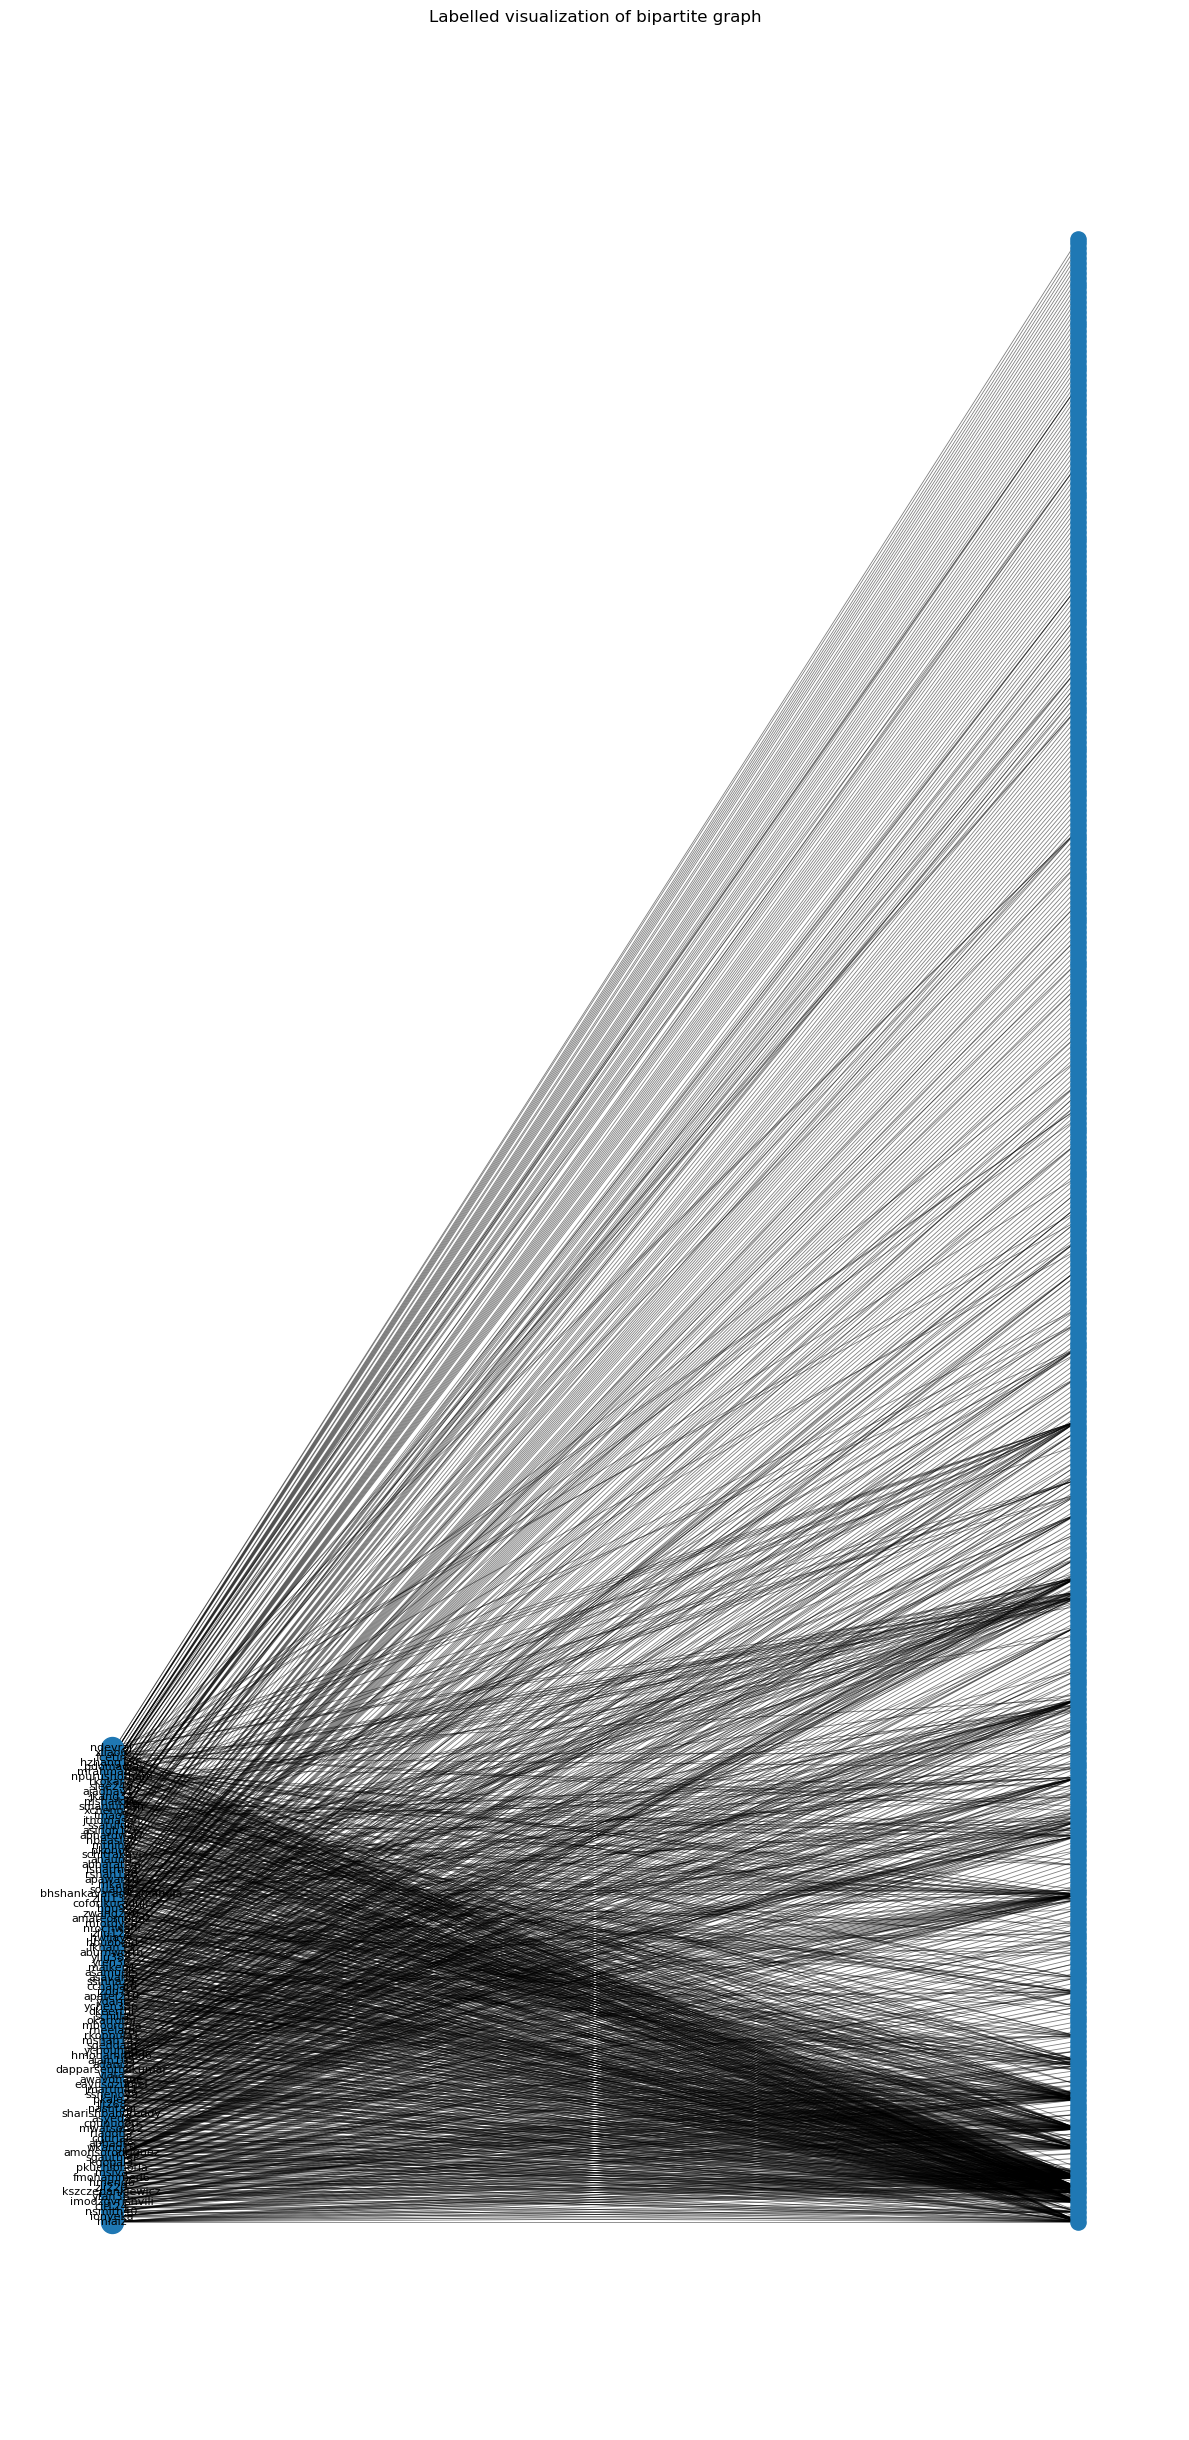

In [58]:
pos_bi = {}
pos_bi.update({n:(0,i) for i,n in enumerate(left)})
pos_bi.update({n:(1,i) for i,n in enumerate(right)})

fig, ax = plt.subplots(figsize=(12, max(8, len(left)*0.25)))
nx.draw_networkx_edges(B, pos_bi, width=0.6, alpha=0.5, ax=ax)
nx.draw_networkx_nodes(B, pos_bi, nodelist=left,  node_size=250, ax=ax)
nx.draw_networkx_nodes(B, pos_bi, nodelist=right, node_size=120, ax=ax)
labels_left = {n: (n.split("@",1)[0] if "@" in n else n) for n in left}
nx.draw_networkx_labels(B, pos_bi, labels=labels_left, font_size=8, ax=ax)

ax.set_title("Labelled visualization of bipartite graph")
ax.set_axis_off()
plt.tight_layout(); plt.show()


# (2c) Project to unimodal (participants)

In [60]:
U = set(left)
G_uni = bp.weighted_projected_graph(B, U)
print(f"Unimodal graph: {G_uni.number_of_nodes()} nodes, {G_uni.number_of_edges()} edges")


Unimodal graph: 98 nodes, 4751 edges


(2c) Description of method for projecting bipartite graph to unimodal graph including code.

After cleaning the dataset into a long edge list of `(participant, entity)` pairs, I built a bipartite graph where one set of nodes represents participants and the other set represents entities. To analyze connections among participants only, I projected this bipartite graph into a unimodal participant graph.

**Method:**
1. Start with the set of participant nodes from the bipartite graph.
2. For each pair of participants, check if they are both connected to at least one common entity.
3. Create an edge between them if such a shared entity exists.
4. Assign the edge weight as the total number of entities they share.

This projection produces a social network of participants, where stronger edges indicate more shared interests or attributes.

**Code (as used in my notebook):**
```python
from networkx.algorithms import bipartite as bp

# 'B' is the bipartite graph created from (participant, entity) edges
U = set(participants)  # the participant nodes
G_unimodal = bp.weighted_projected_graph(B, U)

print(f"Unimodal graph: {G_unimodal.number_of_nodes()} nodes, {G_unimodal.number_of_edges()} edges")


# (2d) Labelled visualization of unimodal graph

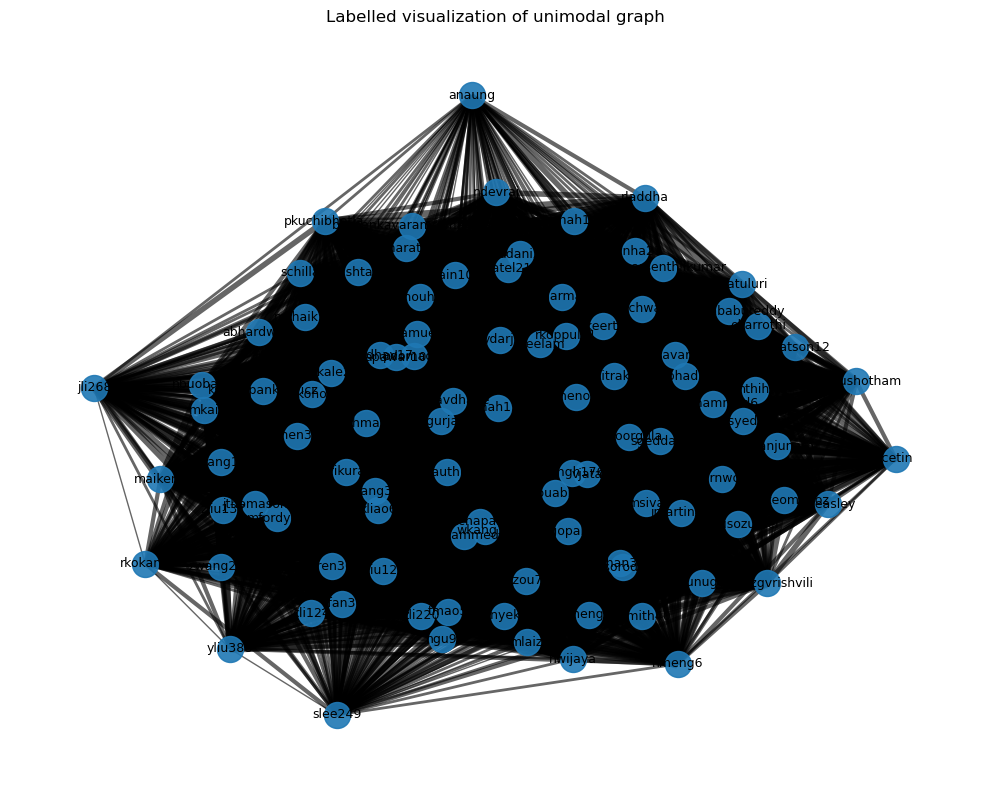

In [62]:
pos = nx.spring_layout(G_uni, seed=7)
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_nodes(G_uni, pos, node_size=350, alpha=0.9, ax=ax)
labels_uni = {n: (n.split("@",1)[0] if "@" in n else n) for n in G_uni.nodes()}
nx.draw_networkx_labels(G_uni, pos, labels=labels_uni, font_size=9, ax=ax)
weights = [G_uni[u][v]["weight"] for u, v in G_uni.edges()]
nx.draw_networkx_edges(G_uni, pos, width=[w for w in weights], alpha=0.6, ax=ax)
ax.set_title("Labelled visualization of unimodal graph")
ax.axis("off"); plt.tight_layout(); plt.show()



# (2e) Plot of degree distribution of unimodal graph

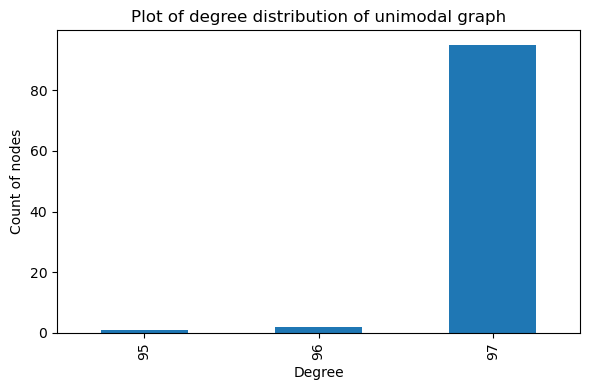

In [64]:
deg_series = pd.Series([d for _, d in G_uni.degree()], name="degree")
fig, ax = plt.subplots(figsize=(6, 4))
deg_series.value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_xlabel("Degree"); ax.set_ylabel("Count of nodes")
ax.set_title("Plot of degree distribution of unimodal graph")
plt.tight_layout(); plt.show()


# (3) Comparison of Degree Distributions

When comparing the degree distribution of the Chicago Community Areas graph (Dataset 1) with the CS 579 Class Participants graph (Dataset 2), we can see clear differences due to how the two networks were built.

**Similarities:**  
- Both graphs are undirected, meaning connections are mutual.  
- In both graphs, most nodes have a moderate number of connections and very high-degree nodes are rare.

**Differences:**  
- **Shape:** The Chicago graph’s degree distribution is fairly narrow, with most areas having only a handful of neighbors. In contrast, the Class Participants graph is more skewed, with many participants connected to just a few others, and some “hub” participants connected to many peers.  
- **Range:** The Chicago degrees are bounded by geography (no area can touch dozens of neighbors), so the range is small. The Class dataset allows wide variation: a common hobby or skill can connect many people, creating larger hubs.  

**Expectation:**  
Yes, this difference is expected. The Chicago network is constrained by physical adjacency, which limits how many connections each area can have. The class social network is based on shared attributes, which naturally leads to uneven distributions and the presence of hubs — a typical property of social networks.


# (4) Citations, References
   For this assignment I used Python in Jupyter Notebook, because it allows code, output, and plots to appear together in one document, making it easier to follow the workflow.

**Tools used:**
- **pandas** for reading and cleaning the datasets, especially normalizing the class dataset from wide form (Name, Entity1–3) into a long edge list.  
- **networkx** for constructing the bipartite and unimodal graphs, and for computing the weighted projection onto participants.  
- **matplotlib** for generating the labeled visualizations and degree distribution plots.  

I chose these tools because they are widely used, well-documented, and provide built-in functions for the type of network analysis required in this assignment.

**References:**
- McKinney, W. (2010). *Data Structures for Statistical Computing in Python.* Proceedings of the 9th Python in Science Conference, 445, 51–56. [pandas documentation](https://pandas.pydata.org/docs/)  
- Hagberg, A. A., Schult, D. A., & Swart, P. J. (2008). *Exploring network structure, dynamics, and function using NetworkX.* Proceedings of the 7th Python in Science Conference, 11–15. [NetworkX documentation](https://networkx.org/documentation/stable/)  
- Hunter, J. D. (2007). *Matplotlib: A 2D graphics environment.* Computing in Science & Engineering, 9(3), 90–95. [Matplotlib documentation](https://matplotlib.org/stable/contents.html)  

**Use of AI:**  
https://chatgpt.com/share/68cb96b5-9f08-800b-95b2-ac79c7a2a1f3
